In [1]:
import simpy, random, logging
from queue_simulation import (
    ServiceOperation, SIMULATION_DURATION, SEED,
    SocialWorkerShifts, DutyOfficerShifts, VolunteerShifts)

import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import itertools

In [2]:
sns.set();

In [3]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager

# modify matplotlib and seaborn settings
# to display Chinese 
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP'] 
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.labelweight'] = 'heavy'
plt.rcParams['font.weight'] = 'medium'

sns.set(font=['sans-serif'])
sns.set_style('dark',{'font.sans-serif':['Noto Serif CJK JP']})
sns.set_context('paper', font_scale=1.5)

# 1. plot counsellor shifts

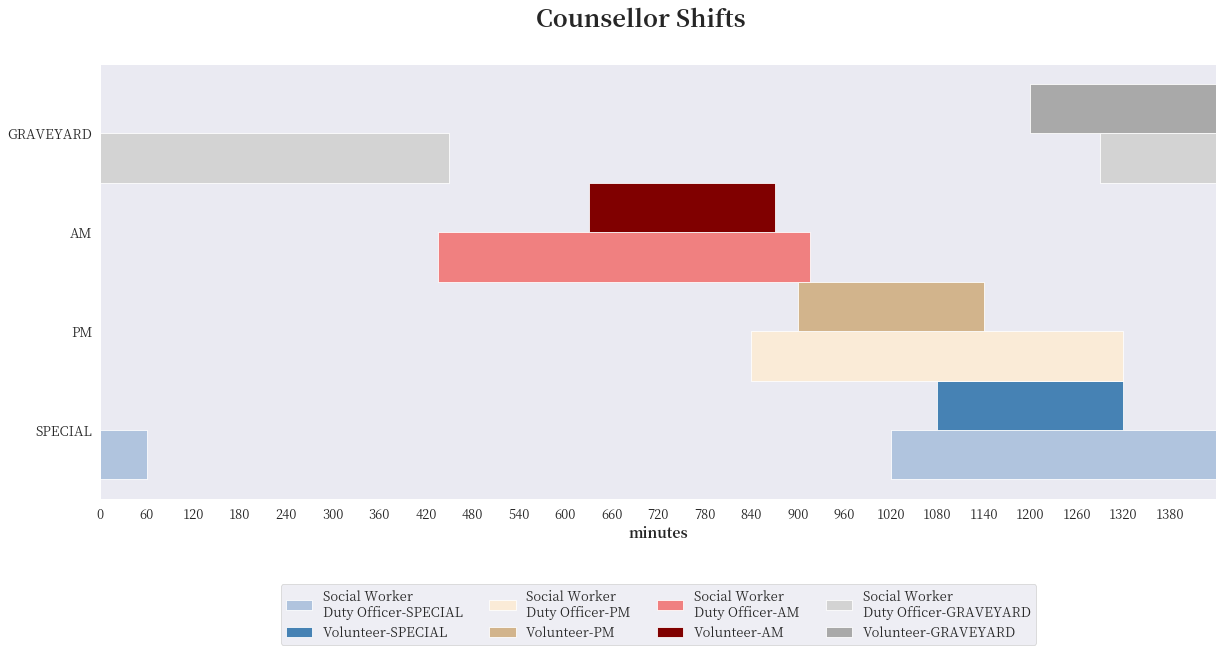

In [4]:
fig, ax = plt.subplots( figsize=(20, 8))
ax.set_xlim(0, 1440)


# special
ax.broken_barh([(SocialWorkerShifts.SPECIAL.start, 1440),
    (0, SocialWorkerShifts.SPECIAL.end%1440)],
    (1, 1), facecolors='lightsteelblue',
    label=f'Social Worker\nDuty Officer-{SocialWorkerShifts.SPECIAL.shift_name}')
ax.broken_barh([(VolunteerShifts.SPECIAL.start,
    VolunteerShifts.PM.duration)],
    (2, 1), facecolors='steelblue',
    label=f'Volunteer-{VolunteerShifts.SPECIAL.shift_name}')


# PM
ax.broken_barh([(SocialWorkerShifts.PM.start,
    SocialWorkerShifts.PM.duration)],
    (3, 1), facecolors='antiquewhite',
    label=f'Social Worker\nDuty Officer-{SocialWorkerShifts.PM.shift_name}'
)
ax.broken_barh([(VolunteerShifts.PM.start,
    VolunteerShifts.PM.duration)],
    (4, 1), facecolors='tan',
    label=f'Volunteer-{VolunteerShifts.PM.shift_name}'
)



# AM
ax.broken_barh([(SocialWorkerShifts.AM.start, 
    SocialWorkerShifts.AM.duration)],
    (5, 1), facecolors='lightcoral',
    label=f'Social Worker\nDuty Officer-{SocialWorkerShifts.AM.shift_name}'
)
ax.broken_barh([(VolunteerShifts.AM.start, 
    VolunteerShifts.AM.duration)],
    (6, 1), facecolors='maroon',
    label=f'Volunteer-{VolunteerShifts.AM.shift_name}'
)


# graveyard
ax.broken_barh([(SocialWorkerShifts.GRAVEYARD.start, 1440),
    (0, SocialWorkerShifts.GRAVEYARD.end%1440)],
    (7, 1), facecolors='lightgrey',
    label=f'Social Worker\nDuty Officer-{SocialWorkerShifts.GRAVEYARD.shift_name}'              
)
ax.broken_barh([(VolunteerShifts.GRAVEYARD.start,
    VolunteerShifts.GRAVEYARD.end)],
    (8, 1), facecolors='darkgrey',
    label=f'Volunteer-{VolunteerShifts.GRAVEYARD.shift_name}',
)


ax.set_xticks([x for x in range(0, 1440, 60)])
ax.set_xlabel('minutes')
ax.set_yticks([x for x in range(2, 9 , 2)])
ax.set_yticklabels([
    SocialWorkerShifts.GRAVEYARD.shift_name,
    SocialWorkerShifts.AM.shift_name,
    SocialWorkerShifts.PM.shift_name,
    SocialWorkerShifts.SPECIAL.shift_name,
    ][::-1])

fig.suptitle('Counsellor Shifts', fontweight='bold', fontsize=24)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.35), ncol=4)

plt.show()

# 2. Queue Simulation (multi-process to speed up bootstrap)

In [5]:
import multiprocessing as mp

In [6]:
manager = mp.Manager()

In [7]:
queue_status = manager.list()
max_queue_length = manager.list()
num_users = manager.list()
num_users_accepted_TOS = manager.list()
num_users_rejected_TOS = manager.list()
num_users_served = manager.list()
num_users_served_g_regular = manager.list()
num_users_served_g_repeated = manager.list()
num_users_reneged = manager.list()
# num_users_reneged_g_regular = manager.list()
# num_users_reneged_g_repeated = manager.list()
num_available_counsellor_processes = manager.list()
queue_time_stats = manager.list()
renege_time_stats = manager.list()

In [8]:
# comment out line if not reproducing results
random.seed(728)
num_iterations = 1500 # this should be multiples of num_cores
num_cores = max(mp.cpu_count()-2, 2)

In [9]:
def run_simulation(
        queue_status,
        max_queue_length,
        num_users,
        num_users_accepted_TOS,
        num_users_rejected_TOS,
        num_users_served,
        num_users_served_g_regular,
        num_users_served_g_repeated,
        num_users_reneged,
        num_available_counsellor_processes,
        queue_time_stats,
        renege_time_stats):

    for i in tqdm(
        range(num_iterations//num_cores), 
        desc='OpenUp Queue Simulation'):

        try:
            # create environment
            env = simpy.Environment() 

            # set up service operation and run simulation until  
            S = ServiceOperation(env=env)
            env.run(until=SIMULATION_DURATION)


            num_users.append(S.num_users)   
            num_users_accepted_TOS.append(S.num_users_TOS_accepted)
            num_users_rejected_TOS.append(S.num_users_TOS_rejected)
            max_queue_length.append(S.user_queue_max_length)
            
            queue_status.append(pd.DataFrame(S.queue_status) )
            num_available_counsellor_processes.append(
                pd.DataFrame(S.num_available_counsellor_processes,
                             columns=['time', 'num_counsellor_processes_idle'])
            )
            
            num_users_served.append(S.served)
            num_users_served_g_regular.append(S.served_g_regular)
            num_users_served_g_repeated.append(S.served_g_repeated)
            num_users_reneged.append(S.reneged)
            
            queue_time_stats.append(pd.DataFrame(S.queue_time_stats) )
            renege_time_stats.append(pd.DataFrame(S.renege_time_stats) )
        #     num_users_reneged_g_regular.append(S.reneged_g_regular)
        #     num_users_reneged_g_repeated.append(S.reneged_g_repeated)
        except ValueError:
            print(f'Negative delay at {i}.  Results are dropped.')

## divide up jobs to `num_cores`, and merge results when complete

In [10]:
jobs = [mp.Process(target=run_simulation, args=[
            queue_status,
            max_queue_length,
            num_users,
            num_users_accepted_TOS,
            num_users_rejected_TOS,
            num_users_served,
            num_users_served_g_regular,
            num_users_served_g_repeated,
            num_users_reneged,
            num_available_counsellor_processes,
            queue_time_stats,
            renege_time_stats
        ]) for i in range(num_cores)]        
    
for j in jobs:
    j.start()
    
    
for j in jobs:
    j.join()

OpenUp Queue Simulation: 100%|██████████| 250/250 [04:33<00:00,  1.09s/it]


## convert to pandas objects

In [11]:
num_users = pd.Series(np.array(num_users), name='number of users')
num_users_accepted_TOS = pd.Series(np.array(num_users_accepted_TOS), name='number of users accepting TOS')
num_users_rejected_TOS = pd.Series(np.array(num_users_rejected_TOS), name='number of users rejecting TOS')
num_users_served = pd.Series(np.array(num_users_served), name='number of users served')
num_users_served_g_regular = pd.Series(np.array(num_users_served_g_regular), name='number of users served')
num_users_served_g_repeated = pd.Series(np.array(num_users_served_g_repeated), name='number of repeated users served')
num_users_reneged = pd.Series(np.array(num_users_reneged), name='number of users reneged')
# num_users_reneged_g_regular = pd.Series(num_users_reneged_g_regular, name='number of users reneged')
# num_users_reneged_g_repeated = pd.Series(num_users_reneged_g_repeated, name='number of repeated users reneged')
queue_status = pd.concat(queue_status)
max_queue_length = pd.Series(np.array(max_queue_length), name='max queue length')
queue_time_stats = pd.concat(queue_time_stats)
renege_time_stats = pd.concat(renege_time_stats)
num_available_counsellor_processes = pd.concat(num_available_counsellor_processes)

In [12]:
# function to calculate classification confidence intervals
# parameter: stats - list of confidence intervals, which must be ordered
#            metadata - any string to annotate printout, can be None
# precondition - metadata must be a string or None, and stats must be a list
#                  The check is commented out for now as asserts should 
#               be done outside function
# returns: cutoff values at 2.5% and 95% percentiles
def calculate_confidence_intervals(stats, metadata=None):
    # if not isinstance(metadata, None) or \
    #     not isinstance(metadata, str) or \
    #     not isinstance(stats, list):
    #     return
        
    confidence_interval = .95 # 95 percent confidence level
    q_lower = .5 * (1 - confidence_interval)
    q_upper = confidence_interval + q_lower
        
    # convert to percentages
    q_lower = q_lower * 100
    q_upper = q_upper * 100
    confidence_interval = confidence_interval * 100
        
    #     print(q_lower, q_upper)
    lower_percentile = np.percentile(stats, q_lower)
    upper_percentile = np.percentile(stats, q_upper)
    mean = np.mean(stats)
        
    print('\n%s %d%% Confidence interval:' % (
        metadata, confidence_interval) )
    print('----------------------------')
    print('%.1f%% percentile: %.5f' % (q_lower, lower_percentile) )
    print('%.1f%% percentile: %.5f\n' % (q_upper, upper_percentile) )
    print('mean value: %.5f' % mean)
    return (lower_percentile, upper_percentile, mean)

In [13]:
def plot_distribution(series, filename):
    confidence_interval = .95 # 95 percent confidence level
    q_lower = .5 * (1 - confidence_interval)
    q_upper = confidence_interval + q_lower
        
    # convert to percentages
    q_lower = q_lower * 100
    q_upper = q_upper * 100
    confidence_interval = confidence_interval * 100
        
    #     print(q_lower, q_upper)
    lower_percentile = np.percentile(series, q_lower)
    upper_percentile = np.percentile(series, q_upper)
    mean = np.mean(series)
    
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 5) )
    sns.distplot(series, ax=ax)
    ax.axvline(x=lower_percentile, linestyle='--' )
    ax.axvline(x=upper_percentile, linestyle='--' )
    ax.axvline(x=mean, linestyle=':', linewidth=2 )
    
    fig.savefig(f'{filename}.png', dpi=300, bbox_inches='tight')

/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


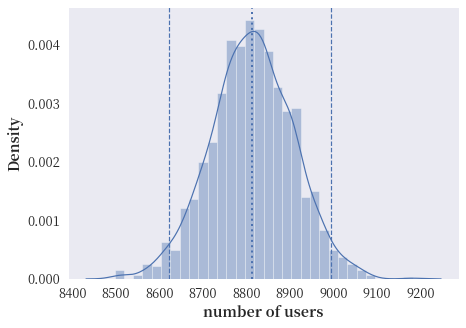

In [14]:
plot_distribution(num_users, 'num_users')

In [15]:
lower, upper, mean = calculate_confidence_intervals(
    num_users.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 8623.00000
97.5% percentile: 8995.00000

mean value: 8813.19733


/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


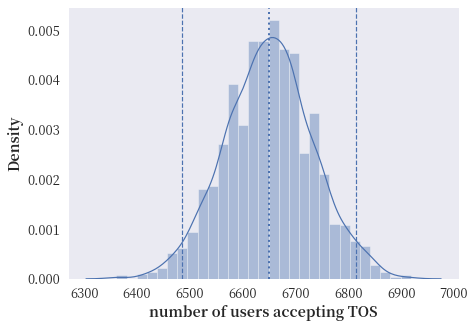

In [16]:
plot_distribution(num_users_accepted_TOS, 'num_users_accepting_TOS')

In [17]:
lower, upper, mean = calculate_confidence_intervals(
    num_users_accepted_TOS.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 6486.00000
97.5% percentile: 6814.57500

mean value: 6649.73733


/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


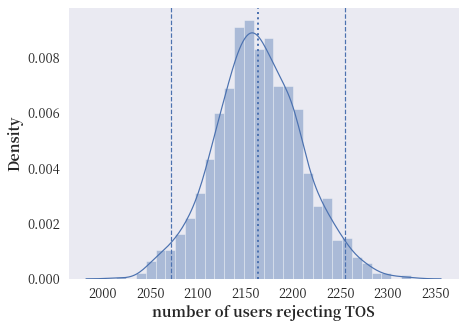

In [18]:
plot_distribution(num_users_rejected_TOS, 'num_users_rejecting_TOS')

In [19]:
lower, upper, mean = calculate_confidence_intervals(
    num_users_rejected_TOS.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 2072.00000
97.5% percentile: 2255.00000

mean value: 2163.46000


/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


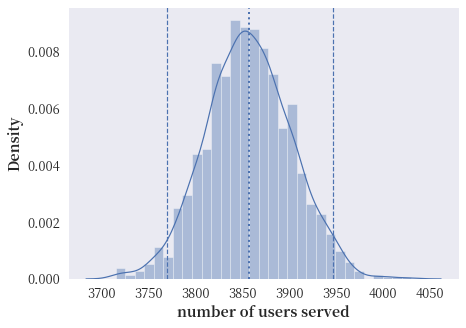

In [20]:
plot_distribution(num_users_served, 'num_users_served')

In [21]:
lower, upper, mean = calculate_confidence_intervals(
    num_users_served.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 3770.00000
97.5% percentile: 3947.00000

mean value: 3856.72200


/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


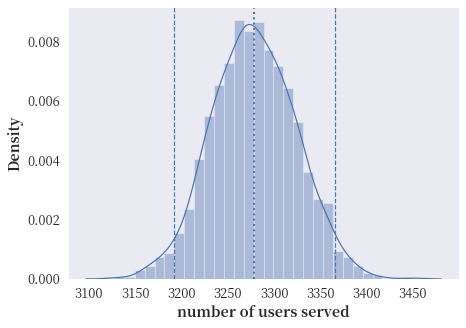

In [22]:
plot_distribution(num_users_served_g_regular, 'num_users_served_g_regular')

In [23]:
lower, upper, mean = calculate_confidence_intervals(
    num_users_served_g_regular.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 3192.00000
97.5% percentile: 3365.52500

mean value: 3278.14200


/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


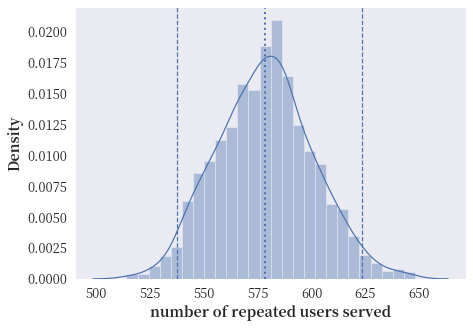

In [24]:
plot_distribution(num_users_served_g_repeated, 'num_users_served_g_repeated')

In [25]:
lower, upper, mean = calculate_confidence_intervals(
    num_users_served_g_repeated.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 537.47500
97.5% percentile: 623.52500

mean value: 578.58000


/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


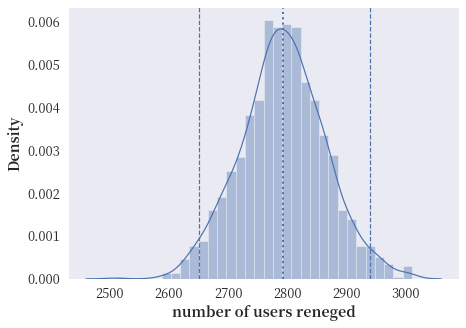

In [26]:
plot_distribution(num_users_reneged, 'num_users_reneged')

In [27]:
lower, upper, mean = calculate_confidence_intervals(
    num_users_reneged.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 2651.47500
97.5% percentile: 2939.52500

mean value: 2793.01267


In [28]:
# plot_distribution(num_users_reneged_g_regular, 'num_users_reneged_g_regular')

In [29]:
# lower, upper, mean = calculate_confidence_intervals(
#     num_users_reneged_g_regular.sort_values().to_list() )

In [30]:
# plot_distribution(num_users_reneged_g_repeated, 'num_users_reneged_g_repeated')

In [31]:
# lower, upper, mean = calculate_confidence_intervals(
#     num_users_reneged_g_repeated.sort_values().to_list() )

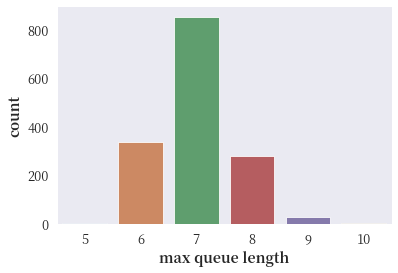

In [32]:
max_queue_length_count = sns.countplot(x='max queue length', data=max_queue_length.to_frame())

max_queue_length_count.get_figure().savefig(f'max_queue_length_count.png', dpi=300, bbox_inches='tight')

In [33]:
queue_status['weekday'].replace({
    0: 'Sunday',
    1: 'Monday',
    2: 'Tuesday',
    3: 'Wednesday',
    4: 'Thursday',
    5: 'Friday',
    6: 'Saturday'
}, inplace=True)

In [34]:
queue_status

,weekday,hour,queue_length
0,Sunday,0,0
1,Sunday,0,0
2,Sunday,0,0
3,Sunday,1,0
4,Sunday,1,0
...,...,...,...
7501,Monday,22,0
7502,Monday,22,0
7503,Monday,23,0
7504,Monday,23,0


In [35]:
queue_status['total']=1

In [36]:
totals = queue_status.groupby(
    ['weekday', 'hour', 'queue_length']).sum()

In [37]:
totals = totals.reset_index()

In [38]:
totals

,weekday,hour,queue_length,total
0,Friday,0,0,35095
1,Friday,0,1,10065
2,Friday,0,2,4474
3,Friday,0,3,2450
4,Friday,0,4,1204
...,...,...,...,...
1035,Wednesday,22,6,128
1036,Wednesday,22,7,22
1037,Wednesday,23,0,20836
1038,Wednesday,23,1,131


In [39]:
totals = pd.pivot_table(totals, values='total', columns=['queue_length'],
              index=['weekday', 'hour'], aggfunc=np.sum, fill_value=0)

In [40]:
totals_percent = totals.div(totals.sum(axis=1), axis=0)#.round(2)

In [41]:
totals_percent

queue_length          0         1         2         3         4         5   \
weekday   hour                                                               
Friday    0     0.653003  0.187277  0.083247  0.045586  0.022403  0.007759   
          1     0.887772  0.101891  0.009632  0.000608  0.000096  0.000000   
          2     0.838731  0.140491  0.018757  0.001775  0.000246  0.000000   
          3     0.795227  0.175387  0.026506  0.002722  0.000158  0.000000   
          4     0.612096  0.241115  0.112177  0.029335  0.004675  0.000521   
...                  ...       ...       ...       ...       ...       ...   
Wednesday 19    0.916530  0.060911  0.019671  0.002888  0.000000  0.000000   
          20    0.999617  0.000354  0.000029  0.000000  0.000000  0.000000   
          21    0.591838  0.130385  0.105509  0.079882  0.050481  0.026506   
          22    0.709980  0.111675  0.083312  0.054050  0.027621  0.010431   
          23    0.993326  0.006245  0.000429  0.000000  0.000000  0.000000   

queue_length          6         7         8         9    10  
weekday   hour                                               
Friday    0     0.000707  0.000019  0.000000  0.000000  0.0  
          1     0.000000  0.000000  0.000000  0.000000  0.0  
          2     0.000000  0.000000  0.000000  0.000000  0.0  
          3     0.000000  0.000000  0.000000  0.000000  0.0  
          4     0.000081  0.000000  0.000000  0.000000  0.0  
...                  ...       ...       ...       ...  ...  
Wednesday 19    0.000000  0.000000  0.000000  0.000000  0.0  
          20    0.000000  0.000000  0.000000  0.000000  0.0  
          21    0.011173  0.003431  0.000751  0.000043  0.0  
          22    0.002500  0.000430  0.000000  0.000000  0.0  
          23    0.000000  0.000000  0.000000  0.000000  0.0  

[168 rows x 11 columns]

In [42]:
totals_percent2 = totals_percent.reset_index()

In [43]:
totals_percent2['day_int'] = totals_percent2['weekday'].map({
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 0,
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4
})

In [44]:
totals_percent2 = totals_percent2.sort_values(
    by=['day_int', 'hour']).reset_index(drop=True).set_index(
    ['weekday', 'hour']).drop(columns=['day_int'])

In [45]:
totals_percent2['>=2'] = totals_percent2[totals_percent2.columns[totals_percent2.columns >= 2]].sum(axis=1)

In [46]:
totals_percent2.reset_index(inplace=True)

In [47]:
totals_percent3 = totals_percent2[['weekday', 'hour', 0, 1, '>=2']].copy()

In [48]:
totals_percent3[totals_percent3['weekday']=='Sunday']

queue_length,weekday,hour,0,1,>=2
0,Sunday,0,0.659888,0.154513,0.185599
1,Sunday,1,0.860162,0.122893,0.016945
2,Sunday,2,0.821384,0.154228,0.024388
3,Sunday,3,0.806764,0.164262,0.028975
4,Sunday,4,0.638344,0.232333,0.129323
5,Sunday,5,0.808217,0.162016,0.029767
6,Sunday,6,0.734083,0.215413,0.050505
7,Sunday,7,0.780992,0.170043,0.048965
8,Sunday,8,0.805306,0.161398,0.033296
9,Sunday,9,0.791751,0.169076,0.039173


In [49]:
from queue_simulation import (
    MINUTES_PER_DAY, DAYS_IN_WEEK, MINUTES_PER_HOUR, 
    MAX_SIMULTANEOUS_CHATS,
    NUM_DUTY_OFFICERS,
    NUM_SOCIAL_WORKERS,
    NUM_VOLUNTEERS
)

In [50]:
NUM_DUTY_OFFICERS

{'GRAVEYARD': 1, 'AM': 1, 'PM': 1, 'SPECIAL': 0}

In [51]:
MAX_SIMULTANEOUS_CHATS

{'SOCIAL_WORKER': 3, 'DUTY_OFFICER': 1, 'VOLUNTEER': 2}

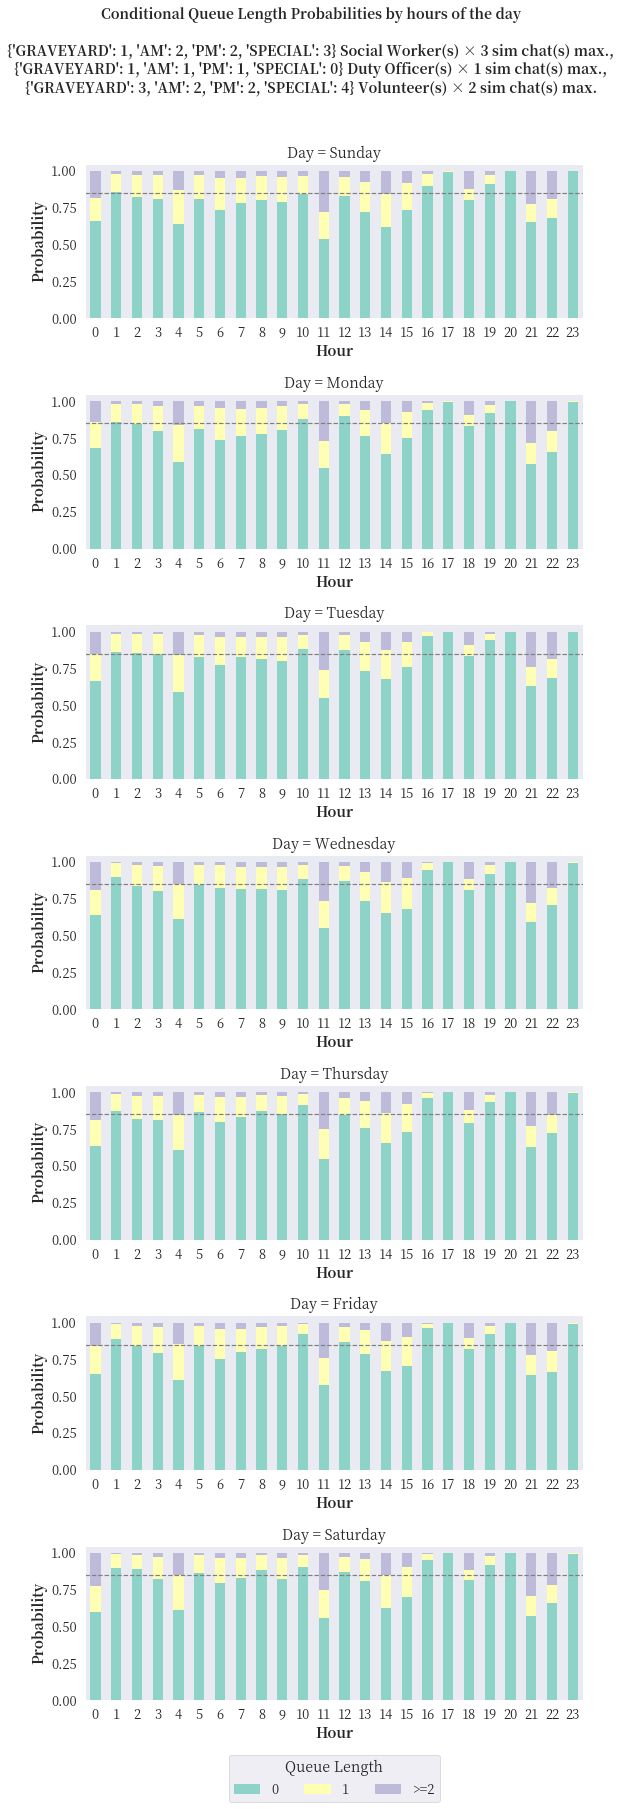

In [52]:
fig, ax = plt.subplots(7, 1, figsize=(8,25) )
palette = sns.color_palette("Set3")

fig.suptitle(f'Conditional Queue Length Probabilities by hours of the day\n\n'
    f'{NUM_SOCIAL_WORKERS} Social Worker(s) × {MAX_SIMULTANEOUS_CHATS["SOCIAL_WORKER"]} sim chat(s) max.,\n'
    f'{NUM_DUTY_OFFICERS} Duty Officer(s) × {MAX_SIMULTANEOUS_CHATS["DUTY_OFFICER"]} sim chat(s) max.,\n'
    f'{NUM_VOLUNTEERS} Volunteer(s) × {MAX_SIMULTANEOUS_CHATS["VOLUNTEER"]} sim chat(s) max.',
    fontsize=14, weight='heavy',
    fontweight=1000, y=1.01)

for i, day in enumerate(
    ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
    'Friday', 'Saturday']):
    
    dataframe = totals_percent3[totals_percent3['weekday']==day].copy()
    dataframe.set_index('hour').plot.bar(
        stacked=True,
        ax=ax[i],
        linewidth=.01,
        color=palette
    )

    ax[i].axhline(y=.85, linestyle='--', color='grey')
#     ax[i].set_xticklabels(labels=[f'{x[:3]}-{x[-1]} hr' 
#         if x[-2:] == '_0' else ''
#         for x in dataframe.index])

    ax[i].set_xlabel('Hour')
    ax[i].set_ylabel('Probability')
    ax[i].set_title(f'Day = {day}')
    ax[i].set_xticklabels(dataframe['hour'], rotation=0)
    
    
    
    if day == 'Saturday':
        ax[i].legend(loc='lower center', 
                     bbox_to_anchor=(0.5, -.7), 
                     ncol=3,
                     title='Queue Length'
                    
                    )
    else:
        ax[i].get_legend().remove()

    
fig.tight_layout()

fig.savefig(f'queue_length_prob_plot.png', dpi=300, bbox_inches='tight')

In [53]:
# queue_plot = sns.catplot(col='weekday', y='hour', col_wrap=4,
#     col_order=['Sunday',
#         'Monday',
#         'Tuesday',
#         'Wednesday',
#         'Thursday',
#         'Friday',
#         'Saturday'],
#     data=queue_status, kind="count",
#     height=4, aspect=1);
# queue_plot.savefig(f'queue_blowup.png', dpi=300, bbox_inches='tight')

In [54]:
queue_time_stats['weekday'].replace({
    0: 'Sunday',
    1: 'Monday',
    2: 'Tuesday',
    3: 'Wednesday',
    4: 'Thursday',
    5: 'Friday',
    6: 'Saturday'
}, inplace=True)

In [55]:
queue_time_stats

,weekday,hour,time_spent_in_queue
0,Sunday,0,0.0
1,Sunday,0,0.0
2,Sunday,0,0.0
3,Sunday,1,0.0
4,Sunday,1,0.0
...,...,...,...
4329,Monday,22,0.0
4330,Monday,22,0.0
4331,Monday,23,0.0
4332,Monday,23,0.0


In [56]:
queue_time_stats['total']=1

In [57]:
# # totals = 
# queue_time_stats.mean()

In [58]:
queue_time_stats['queue_time_group'] = queue_time_stats['time_spent_in_queue'].apply(
    lambda x: 'direct' if x==0 else '<=5 minutes' if x<=5 and x>0 else '>5 minutes')

In [59]:
queue_time_stats['queue_time_group']

0       direct
1       direct
2       direct
3       direct
4       direct
         ...  
4329    direct
4330    direct
4331    direct
4332    direct
4333    direct
Name: queue_time_group, Length: 6478047, dtype: object

In [60]:
queue_time_stats = pd.pivot_table(queue_time_stats, values='total', columns=['queue_time_group'],
              index=['weekday', 'hour'], aggfunc=np.sum, fill_value=0)

In [61]:
queue_time_stats

queue_time_group  <=5 minutes  >5 minutes  direct
weekday   hour                                   
Friday    0              2344         309   16517
          1              1491         177   10230
          2              1978         233   11012
          3              2603         365   10566
          4              1207         175    5037
...                       ...         ...     ...
Wednesday 19               21           0   47330
          20               19           0   33829
          21             1171         130   38739
          22              570          45   48210
          23              298          29   19579

[168 rows x 3 columns]

In [62]:
queue_time_stats.div(queue_time_stats.sum(axis=1), axis=0)

queue_time_group  <=5 minutes  >5 minutes    direct
weekday   hour                                     
Friday    0          0.122274    0.016119  0.861607
          1          0.125315    0.014876  0.859808
          2          0.149588    0.017621  0.832791
          3          0.192330    0.026969  0.780700
          4          0.188036    0.027263  0.784702
...                       ...         ...       ...
Wednesday 19         0.000443    0.000000  0.999557
          20         0.000561    0.000000  0.999439
          21         0.029246    0.003247  0.967507
          22         0.011674    0.000922  0.987404
          23         0.014970    0.001457  0.983573

[168 rows x 3 columns]

In [63]:
queue_time_stats_percent = (queue_time_stats.div(queue_time_stats.sum(axis=1), axis=0))#.round(2)

In [64]:
queue_time_stats

queue_time_group  <=5 minutes  >5 minutes  direct
weekday   hour                                   
Friday    0              2344         309   16517
          1              1491         177   10230
          2              1978         233   11012
          3              2603         365   10566
          4              1207         175    5037
...                       ...         ...     ...
Wednesday 19               21           0   47330
          20               19           0   33829
          21             1171         130   38739
          22              570          45   48210
          23              298          29   19579

[168 rows x 3 columns]

In [65]:
queue_time_stats2 = queue_time_stats_percent.reset_index()

In [66]:
queue_time_stats2['day_int'] = queue_time_stats2['weekday'].map({
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 0,
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4
})

In [67]:
queue_time_stats2 = queue_time_stats2.sort_values(
    by=['day_int', 'hour']).reset_index(drop=True).set_index(
    ['weekday', 'hour']).drop(columns=['day_int'])

In [68]:
queue_time_stats2

queue_time_group  <=5 minutes  >5 minutes    direct
weekday  hour                                      
Sunday   0           0.084421    0.011488  0.904091
         1           0.129174    0.015130  0.855696
         2           0.174457    0.020109  0.805434
         3           0.188359    0.024765  0.786876
         4           0.193519    0.025803  0.780679
...                       ...         ...       ...
Saturday 19          0.001491    0.000075  0.998434
         20          0.000980    0.000030  0.998990
         21          0.032748    0.003622  0.963631
         22          0.004568    0.000505  0.994927
         23          0.009835    0.000637  0.989528

[168 rows x 3 columns]

In [69]:
queue_time_stats2.reset_index(inplace=True)

In [70]:
queue_time_stats2

queue_time_group,weekday,hour,<=5 minutes,>5 minutes,direct
0,Sunday,0,0.084421,0.011488,0.904091
1,Sunday,1,0.129174,0.015130,0.855696
2,Sunday,2,0.174457,0.020109,0.805434
3,Sunday,3,0.188359,0.024765,0.786876
4,Sunday,4,0.193519,0.025803,0.780679
...,...,...,...,...,...
163,Saturday,19,0.001491,0.000075,0.998434
164,Saturday,20,0.000980,0.000030,0.998990
165,Saturday,21,0.032748,0.003622,0.963631
166,Saturday,22,0.004568,0.000505,0.994927


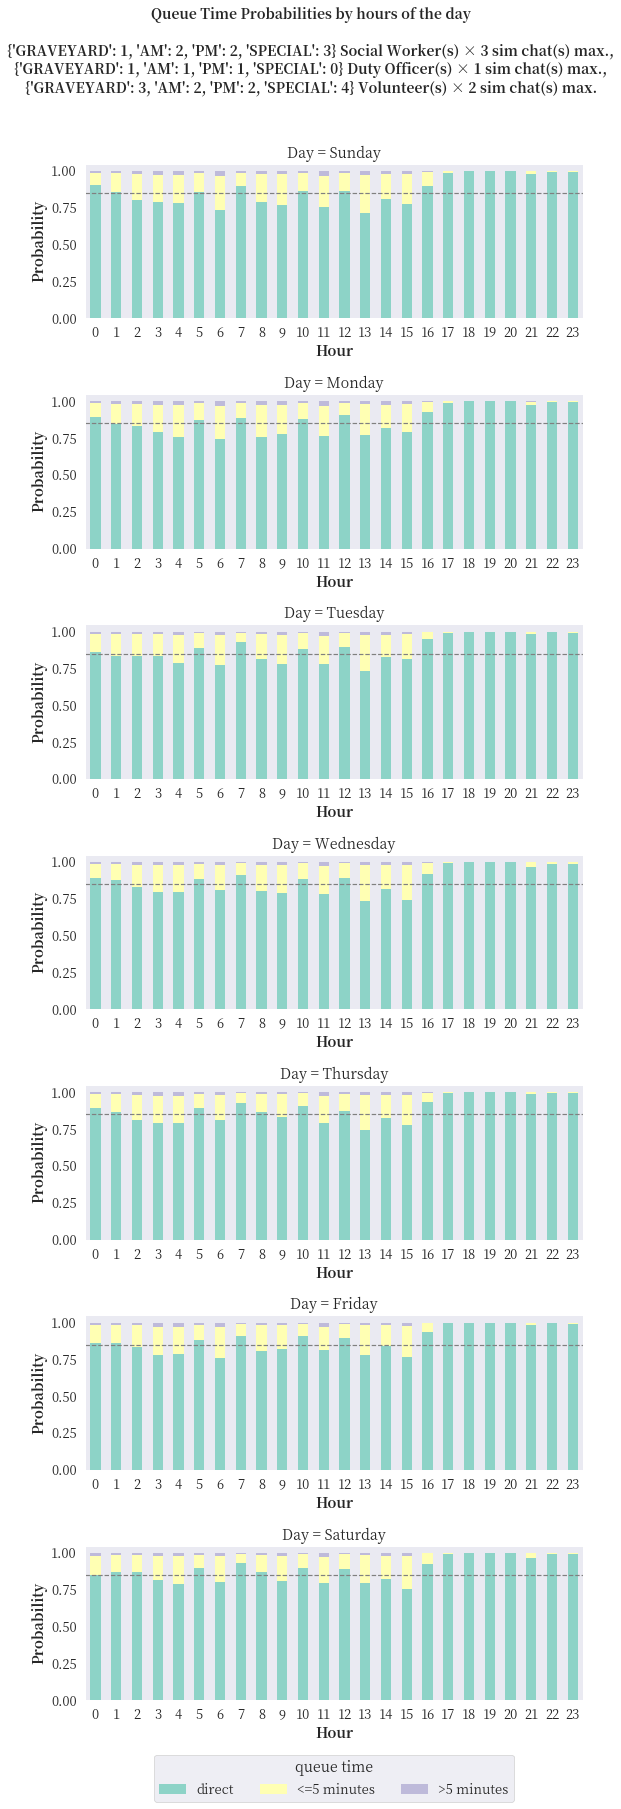

In [71]:
fig, ax = plt.subplots(7, 1, figsize=(8,25) )
palette = sns.color_palette("Set3")

fig.suptitle(f'Queue Time Probabilities by hours of the day\n\n'
    f'{NUM_SOCIAL_WORKERS} Social Worker(s) × {MAX_SIMULTANEOUS_CHATS["SOCIAL_WORKER"]} sim chat(s) max.,\n'
    f'{NUM_DUTY_OFFICERS} Duty Officer(s) × {MAX_SIMULTANEOUS_CHATS["DUTY_OFFICER"]} sim chat(s) max.,\n'
    f'{NUM_VOLUNTEERS} Volunteer(s) × {MAX_SIMULTANEOUS_CHATS["VOLUNTEER"]} sim chat(s) max.',
    fontsize=14, weight='heavy',
    fontweight=1000, y=1.01)

for i, day in enumerate(
    ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
    'Friday', 'Saturday']):
    
    dataframe = queue_time_stats2[queue_time_stats2['weekday']==day].copy()
    dataframe[['weekday', 'hour', 'direct', 
         '<=5 minutes', '>5 minutes']
    ].set_index('hour').plot.bar(
        stacked=True,
        ax=ax[i],
        linewidth=.01,
        color=palette
    )

    ax[i].axhline(y=.85, linestyle='--', color='grey')

    ax[i].set_xlabel('Hour')
    ax[i].set_ylabel('Probability')
    ax[i].set_title(f'Day = {day}')
    ax[i].set_xticklabels(dataframe['hour'], rotation=0)
    
    
    
    if day == 'Saturday':
        ax[i].legend(loc='lower center', 
                     bbox_to_anchor=(0.5, -.7), 
                     ncol=3,
                     title='queue time'
                    
                    )
    else:
        ax[i].get_legend().remove()

    
fig.tight_layout()

fig.savefig(f'queue_length_prob_plot.png', dpi=300, bbox_inches='tight')

# determine hours counsellors are maxed out

In [72]:
from queue_simulation import (
    MINUTES_PER_DAY, DAYS_IN_WEEK, MINUTES_PER_HOUR)

In [73]:
num_available_counsellor_processes

,time,num_counsellor_processes_idle
0,1.909258,12
1,11.445309,11
2,16.416057,10
3,67.143934,2
4,100.316814,2
...,...,...
7501,43095.236211,17
7502,43139.429014,16
7503,43142.304129,16
7504,43143.568901,15


In [74]:
num_available_counsellor_processes['time_int'] = num_available_counsellor_processes['time'].astype(int)

In [75]:
num_available_counsellor_processes['current_day_minutes'] = num_available_counsellor_processes['time_int'] % MINUTES_PER_DAY

In [76]:
num_available_counsellor_processes['weekday'] = (num_available_counsellor_processes['time_int'] / MINUTES_PER_DAY).astype(int) % DAYS_IN_WEEK

In [77]:
num_available_counsellor_processes['hour'] = (num_available_counsellor_processes['current_day_minutes'] / MINUTES_PER_HOUR).astype(int)

In [78]:
num_available_counsellor_processes['day_of_week'] = num_available_counsellor_processes['weekday'].replace({
    0: 'Sunday',
    1: 'Monday',
    2: 'Tuesday',
    3: 'Wednesday',
    4: 'Thursday',
    5: 'Friday',
    6: 'Saturday'
})

In [79]:
num_available_counsellor_processes['total']=1

In [80]:
num_available_counsellor_processes

,time,num_counsellor_processes_idle,time_int,current_day_minutes,weekday,hour,day_of_week,total
0,1.909258,12,1,1,0,0,Sunday,1
1,11.445309,11,11,11,0,0,Sunday,1
2,16.416057,10,16,16,0,0,Sunday,1
3,67.143934,2,67,67,0,1,Sunday,1
4,100.316814,2,100,100,0,1,Sunday,1
...,...,...,...,...,...,...,...,...
7501,43095.236211,17,43095,1335,1,22,Monday,1
7502,43139.429014,16,43139,1379,1,22,Monday,1
7503,43142.304129,16,43142,1382,1,23,Monday,1
7504,43143.568901,15,43143,1383,1,23,Monday,1


In [81]:
df2 = pd.pivot_table(num_available_counsellor_processes, values='total', columns=['num_counsellor_processes_idle'],
              index=[#'weekday', 'day_of_week', 
                     'hour'], aggfunc=np.sum, fill_value=0)

In [82]:
df2 = (((df2.T/df2.T.sum()).T)*100)#.round(2)

In [83]:
# df2 = df2.reset_index(drop=False).drop(columns=['weekday'])
# selection = df2[df2['day_of_week']=='Monday'].copy()

In [84]:
# df2.groupby('hour').mean()

In [85]:
# selection.set_index(['day_of_week', 'hour']).to_excel(
#     'queue_output/num_idle_procs_SW_2434_DO_11_V_2423-45.xlsx')

In [86]:
queue_time_stats

queue_time_group  <=5 minutes  >5 minutes  direct
weekday   hour                                   
Friday    0              2344         309   16517
          1              1491         177   10230
          2              1978         233   11012
          3              2603         365   10566
          4              1207         175    5037
...                       ...         ...     ...
Wednesday 19               21           0   47330
          20               19           0   33829
          21             1171         130   38739
          22              570          45   48210
          23              298          29   19579

[168 rows x 3 columns]

In [87]:
renege_time_stats['weekday'].replace({
    0: 'Sunday',
    1: 'Monday',
    2: 'Tuesday',
    3: 'Wednesday',
    4: 'Thursday',
    5: 'Friday',
    6: 'Saturday'
}, inplace=True)

In [88]:
renege_time_stats['time_spent_in_queue'].describe()

count    4.722705e+06
mean     2.030709e+00
std      2.020870e+00
min      1.417626e-07
25%      5.882079e-01
50%      1.412859e+00
75%      2.817526e+00
max      2.946529e+01
Name: time_spent_in_queue, dtype: float64

<AxesSubplot:xlabel='time_spent_in_queue', ylabel='Density'>

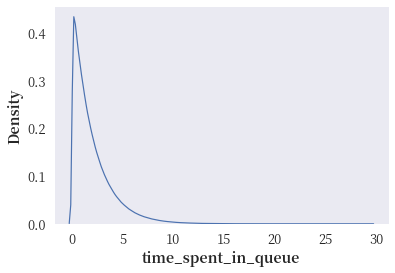

In [89]:
sns.kdeplot(renege_time_stats['time_spent_in_queue'])

<AxesSubplot:xlabel='hour', ylabel='Count'>

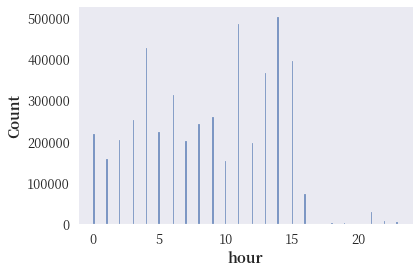

In [90]:
sns.histplot(renege_time_stats['hour'])

In [91]:
df2

num_counsellor_processes_idle,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
hour,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.003093,0.004780,0.026709,0.170938,1.170980,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,45.545520,49.643507,4.198653,0.612320,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,44.019431,52.723454,2.942400,0.314715,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.817751,94.866753,3.861159,0.454338,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1.542243,96.973724,1.346124,0.137909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,1.357702,74.840211,11.984065,11.818023,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,1.835913,94.359864,3.325684,0.478540,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,1.054569,45.154088,15.135879,9.426598,7.226412,5.542030,5.188726,5.738179,3.955228,1.383726,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,1.943494,83.984739,9.430316,3.409750,0.999853,0.206563,0.025284,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [92]:
df2['>29'] = df2[df2.columns[df2.columns > 29]].T.sum()

In [93]:
df2

num_counsellor_processes_idle,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,>29
hour,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.003093,0.004780,0.026709,0.170938,1.170980,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,45.545520,49.643507,4.198653,0.612320,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,44.019431,52.723454,2.942400,0.314715,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,0.817751,94.866753,3.861159,0.454338,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,1.542243,96.973724,1.346124,0.137909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
5,1.357702,74.840211,11.984065,11.818023,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
6,1.835913,94.359864,3.325684,0.478540,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
7,1.054569,45.154088,15.135879,9.426598,7.226412,5.542030,5.188726,5.738179,3.955228,1.383726,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
8,1.943494,83.984739,9.430316,3.409750,0.999853,0.206563,0.025284,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [94]:
# df2.drop(columns=[x for x in range(30,33)], inplace=True)

In [95]:
df2 = df2.T

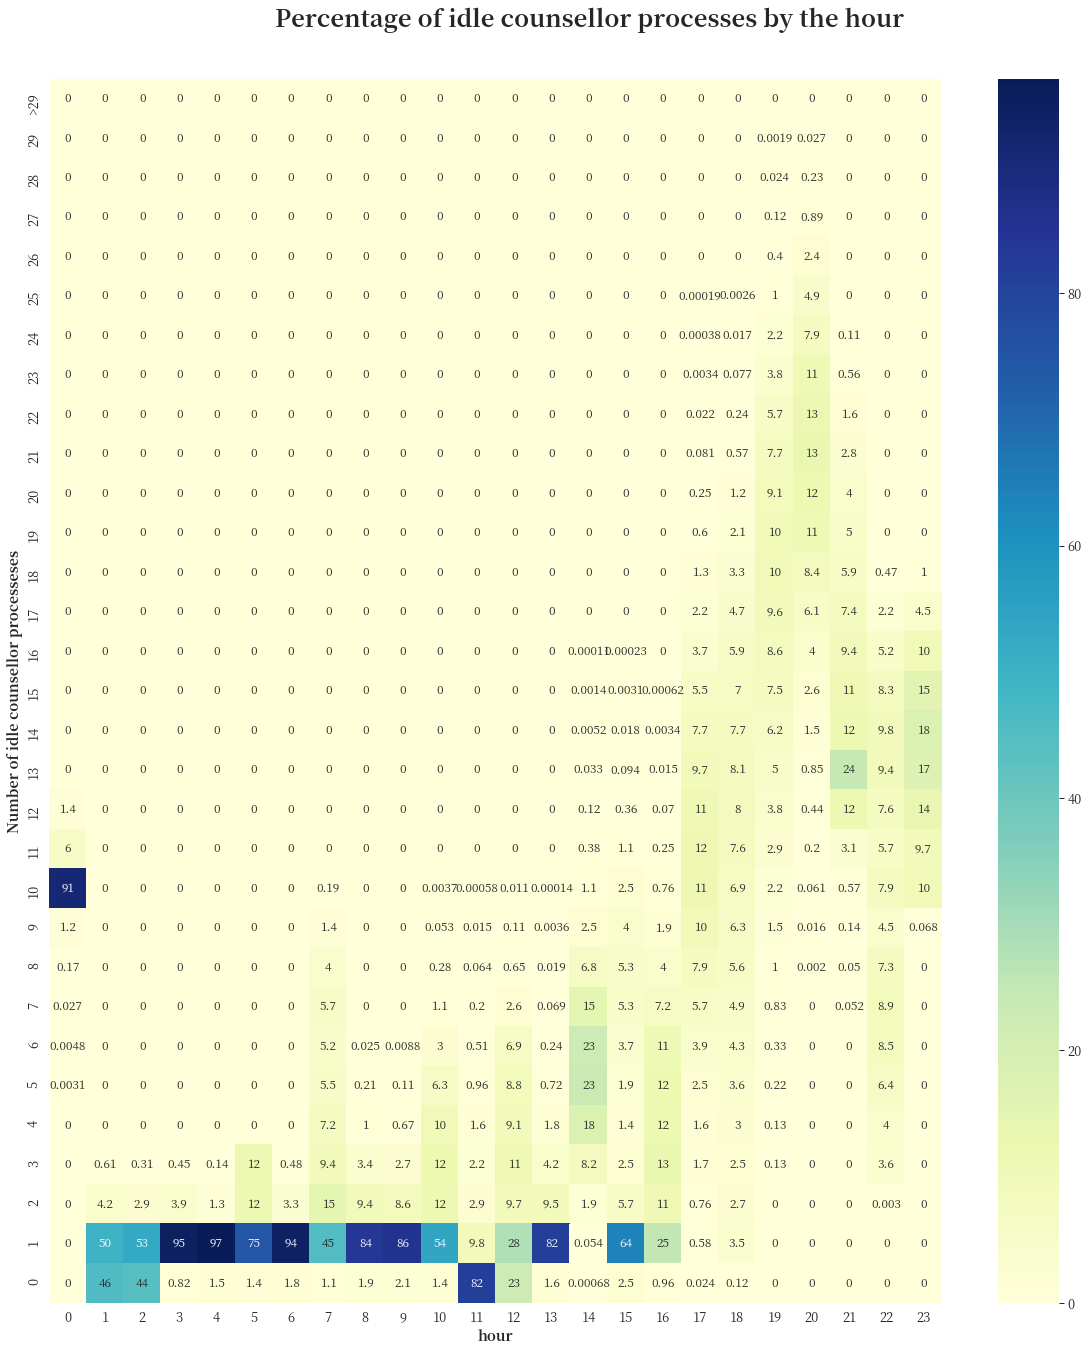

In [96]:
fig, ax = plt.subplots(figsize=(20, 25) )


sns.heatmap(df2[::-1], annot=True, ax=ax, annot_kws={"size": 12}, 
    cmap="YlGnBu",
);
fig.suptitle('Percentage of idle counsellor processes by the hour',
    fontsize=24, weight='heavy',
    fontweight=1000, y=.92)
plt.subplots_adjust(bottom=0.2)
ax.set_ylabel('Number of idle counsellor processeses')

# # workaround from https://github.com/mwaskom/seaborn/issues/1773
# b, t = plt.ylim() # discover the values for bottom and top
# b += 0.5 # Add 0.5 to the bottom
# t -= 0.5 # Subtract 0.5 from the top
# plt.ylim(b, t) # update the ylim(bottom, top) values
# plt.show() # ta-da!

# fig.savefig(f'queue_output/Queue_SW_24_DO_11_V_21.png', dpi=300, bbox_inches='tight')
plt.show()

In [97]:
df2

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
num_counsellor_processes_idle,,,,,,,,,,,,,,,,,,,,,
0,0.000000,45.545520,44.019431,0.817751,1.542243,1.357702,1.835913,1.054569,1.943494,2.143223,...,0.000680,2.523821,0.963397,0.023776,0.115174,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,49.643507,52.723454,94.866753,96.973724,74.840211,94.359864,45.154088,83.984739,85.723237,...,0.054036,63.743602,25.232943,0.582037,3.527752,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,4.198653,2.942400,3.861159,1.346124,11.984065,3.325684,15.135879,9.430316,8.595458,...,1.895919,5.655328,11.293124,0.764827,2.748588,0.000000,0.000000,0.000000,0.003025,0.000000
3,0.000000,0.612320,0.314715,0.454338,0.137909,11.818023,0.478540,9.426598,3.409750,2.746121,...,8.206399,2.521036,13.188917,1.670978,2.523688,0.132550,0.000000,0.000000,3.620877,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.226412,0.999853,0.671031,...,18.161448,1.414993,12.073003,1.623997,2.978185,0.130950,0.000000,0.000000,4.044074,0.000000
5,0.003093,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.542030,0.206563,0.112167,...,23.448634,1.911377,12.246551,2.546506,3.640671,0.220828,0.000000,0.000000,6.436031,0.000000
6,0.004780,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.188726,0.025284,0.008763,...,22.541796,3.651916,10.872962,3.914673,4.272533,0.332575,0.000000,0.000000,8.545969,0.000000
7,0.026709,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.738179,0.000000,0.000000,...,14.834639,5.256781,7.187624,5.664967,4.888424,0.834238,0.000000,0.052160,8.933872,0.000000
8,0.170938,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.955228,0.000000,0.000000,...,6.756931,5.263048,3.966381,7.937764,5.613477,1.000659,0.001959,0.049892,7.311334,0.000000
